<a href="https://www.kaggle.com/code/oscarfraley/fpl-predictive-model?scriptVersionId=161974034" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import seaborn as sns

# Data Exploration

All data is aquired from https://github.com/vaastav/Fantasy-Premier-League which provides the statistics of every FPL player for each gameweek.

In [2]:
example_url = 'https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2023-24/gws/gw5.csv'
example_data = pd.read_csv(example_url)

In [3]:
example_data.head()

,name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,element,...,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards
0,Femi Seriki,DEF,Sheffield Utd,-0.5,0,0,0,0,0.0,653,...,1,2,0.0,0,188,644,456,40,False,0
1,Radek Vítek,GK,Man Utd,0.5,0,0,0,0,0.0,669,...,3,1,0.0,0,230,375,145,40,True,0
2,Jack Hinshelwood,MID,Brighton,-0.5,0,0,0,0,0.0,621,...,3,1,0.0,0,33,171,138,45,False,0
3,Jadon Sancho,MID,Man Utd,0.0,0,0,0,0,0.0,397,...,3,1,0.0,0,-10596,796,11392,68,True,0
4,Divock Origi,FWD,Nott'm Forest,2.0,0,0,3,0,0.0,714,...,1,1,4.0,1,6189,6982,793,50,True,0


The plan is to predict the amount of points each player will score the coming gameweek, based on informationb about their form and upcoming fixture.

# Data Extraction Class

Raw data is manipulated into a dataframe in which each index represents a player from a specific gameweek and contains form (average: xG, xA ...) and fixture (opposition average xGC, home/away) information. The target variable is the players true points scored that particular gameweek.

This class takes a particular gameweek-season pair, and produces a dataframe that is constructed in the form outlined above. 

In [4]:
class PlayerData: # Base class containing functions used in training and prediction.
    def __init__(self, gw, season, form_range=4):
        self.gw = gw
        self.range = form_range
        self.season = season
        self.form_data = self.get_form_data()
        
    def get_url(self, lag): 
        return 'https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/20' \
               + str(self.season) + '-' + str(self.season + 1) + '/gws/gw' + str(self.gw - lag) + '.csv'

    def get_form_data(self): # Extracts recent player statistics and calculated an average.
        data = pd.DataFrame()
        for i in range(self.range):
            url = self.get_url(i+1)
            temp = pd.read_csv(url).drop(['kickoff_time', 'was_home', 'expected_goals_conceded', 'starts', 'element', 'team_a_score', 'team_h_score', 'round', 'penalties_missed', 'penalties_saved', 'own_goals'], axis=1)
            temp = temp.groupby(['name', 'position', 'team']).mean()
            data = pd.concat([data, temp])
        data = data.groupby(['name', 'position', 'team']).mean().reset_index(['position'])
        return data

    def calculate_team_defence(self): # Calculates the average xG conceded in recent weeks by each team.
        data = []
        for n in range(self.range):
            temp = pd.read_csv(self.get_url(n+1))
            temp = temp.loc[temp.minutes == 90][['team', 'expected_goals_conceded']]
            data.append(temp.groupby('team').mean()) 
        return pd.concat([data[i] for i in range(self.range)]).groupby('team').mean().expected_goals_conceded
            
    def calculate_team_attack(self): # Calculates the average xG generated in recent weeks by each team.
        data = []
        for n in range(self.range):
            temp = pd.read_csv(self.get_url(n+1))
            temp = temp[['name','team', 'expected_goals']].groupby(['name', 'team']).mean().groupby(['team']).sum()
            data.append(temp)   
        return pd.concat([data[i] for i in range(self.range)]).groupby('team').mean().expected_goals


class TrainData(PlayerData): # Inherited class to create dataframe for training a model.
    def __init__(self, gw, season, form_range=4):
        super().__init__(gw, season, form_range=4)
        self.fixture_data = self.training_fixture_data()
        self.df = self.create_final_df()

    def training_fixture_data(self): # Extracts fixture related data for each player.
        url = self.get_url(0)
        data = pd.read_csv(url)
        data = data[['name', 'team', 'was_home', 'total_points', 'opponent_team']]
        data = data.rename(columns={'total_points': 'points_scored'})
        data = self.add_team_stats(data)
        return data

    def add_team_stats(self, data):
        team_defence = self.calculate_team_defence()
        team_attack = self.calculate_team_attack()
        data['opponent_defence'] = data.opponent_team.apply(lambda x: team_defence[x-1])
        data['opponent_attack'] = data.opponent_team.apply(lambda x: team_attack[x-1])
        data['team_defence'] = data.team.apply(lambda x: team_defence[x])
        data = data.drop(['opponent_team'], axis=1).groupby(['name', 'team']).mean()
        data = data[data['was_home'] % 1 == 0]
        return data

    def create_final_df(self): # Joins the fixture and form data to create final dataframe for training
        df = self.form_data.join(self.fixture_data, on=['name', 'team'])
        df_refined = df[(df.points_scored.isnull() == False) & (df.minutes > 0)] 
        return df_refined

                            
class PredData(PlayerData): # Inherited class to create predictions about upcoming fixtures.
    def __init__(self, gw, look_ahead=0, form_range=4, season=23):
        super().__init__(gw, season, form_range)
        self.look_ahead = look_ahead
        self.df = self.get_prediction_data()       
        
    def get_prediction_data(self): # Creates datafame for prediction
        fixtures = self.load_fixtures_data()
        form = self.form_data.reset_index(['team']).replace({'Nott\'m Forest': 'Forest'})
        mapping = self.map_fixtures_to_corresponding_players(form, fixtures)
        data = self.join_form_and_fixture_data(form, mapping)
        data = self.add_team_stats(data)
        return data

    def load_fixtures_data(self): # Extracts fixtures from external csv file.
        fixtures = pd.read_csv('/kaggle/input/prem-fixtures/fixtures.csv', usecols=['Round Number', 'Home Team', 'Away Team'])
        fixtures = fixtures.replace({'Nottingham Forest': 'Forest'})
        return fixtures[(fixtures['Round Number'] == self.gw + self.look_ahead)]
    
    def map_fixtures_to_corresponding_players(self, form, fixtures):
        dictionary = {}
        for i, team in enumerate(form.team):
            if (fixtures['Home Team'] == team).any():
                home = 1
                oppo = fixtures[(fixtures['Home Team'] == team)]['Away Team'].item()
                dictionary[i] = []
                dictionary[i].append(home)
                dictionary[i].append(oppo)
            else:
                home = 0
                oppo = fixtures[(fixtures['Away Team'] == team)]['Home Team'].item()
                dictionary[i] = []
                dictionary[i].append(home)
                dictionary[i].append(oppo)
        return dictionary
    
    def add_team_stats(self, data):
        team_defence = self.calculate_team_defence()
        team_attack = self.calculate_team_attack()
        data['opponent_defence'] = data.oppo.apply(lambda x: team_defence[x])
        data['opponent_attack'] = data.oppo.apply(lambda x: team_attack[x])
        data['team_defence'] = data.team.apply(lambda x: team_defence[x])
        return data

    def join_form_and_fixture_data(self, form, mapping):
        df = pd.DataFrame(mapping).transpose().set_index(form.index)
        df.columns = ['was_home', 'oppo']
        return form.join(df, on=['name']).replace({'Forest': 'Nott\'m Forest'})


# Explore Dataset

Now we contruct the dataset by concatenating multiple instances of the data extraction class. This dataset contains players of all positions. xG stats were only recoreded from GW17 of 2022/2023 season.

In [5]:
data = TrainData(gw=21, season=22, form_range=4).df
for i in range(17):
    data = pd.concat([data, TrainData(gw=22+i, season=22, form_range=4).df])
for i in range(18):
    data = pd.concat([data, TrainData(gw=5+i, season=23, form_range=4).df])

In [6]:
data.head()

,,position,xP,assists,bonus,bps,clean_sheets,creativity,expected_assists,expected_goal_involvements,expected_goals,...,transfers_balance,transfers_in,transfers_out,value,yellow_cards,was_home,points_scored,opponent_defence,opponent_attack,team_defence
name,team,,,,,,,,,,,,,,,,,,,,,
Aaron Cresswell,West Ham,DEF,0.850,0.0,0.00,10.50,0.00,8.1000,0.043515,0.059340,0.015825,...,-28009.00,9408.50,37417.50,48.0,0.00,1.0,0.0,1.533588,1.136000,1.511475
Aaron Ramsdale,Arsenal,GK,4.050,0.0,0.75,21.75,0.50,0.0000,0.003710,0.003710,0.000000,...,17570.25,106218.25,88648.00,49.0,0.00,1.0,1.0,0.613070,2.148550,1.208575
Aaron Wan-Bissaka,Man Utd,DEF,7.500,0.0,0.75,23.00,0.75,16.0125,0.059899,0.064361,0.004463,...,18199.25,23152.25,4953.00,43.0,0.00,0.0,1.0,1.208575,1.954200,0.613070
Abdoulaye Doucouré,Everton,MID,0.550,0.0,0.00,1.00,0.00,0.2500,0.001380,0.016830,0.015450,...,-34.25,168.25,202.50,53.0,0.25,0.0,0.0,1.511475,1.210325,1.533588
Adam Armstrong,Southampton,FWD,1.125,0.0,0.00,2.75,0.00,0.4000,0.004960,0.018385,0.013425,...,-3147.25,6326.50,9473.75,55.0,0.00,1.0,2.0,1.603725,1.301225,1.237050


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 13498 entries, ('Aaron Cresswell', 'West Ham') to ('Đorđe Petrović', 'Chelsea')
Data columns (total 32 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   position                    13498 non-null  object 
 1   xP                          13498 non-null  float64
 2   assists                     13498 non-null  float64
 3   bonus                       13498 non-null  float64
 4   bps                         13498 non-null  float64
 5   clean_sheets                13498 non-null  float64
 6   creativity                  13498 non-null  float64
 7   expected_assists            13498 non-null  float64
 8   expected_goal_involvements  13498 non-null  float64
 9   expected_goals              13498 non-null  float64
 10  fixture                     13498 non-null  float64
 11  goals_conceded              13498 non-null  float64
 12  goals_scored                13498 

Since the data is already cleaned in the PlayerData class, this dataset is essentially ready to be used for analysis.

In [8]:
ATT_FEATURES = ['goals_scored', 'expected_goals', 'threat', '']

In [9]:
GKS_FEATURES = ['value', 'minutes', 'transfers_balance', 'selected', 'bps', 'bonus', 'ict_index', 'was_home', 'total_points', 'threat', 'creativity', 'opponent_attack', 'team_defence', 'saves']
DEF_FEATURES = ['value', 'minutes', 'transfers_balance', 'selected', 'bps', 'bonus', 'ict_index', 'was_home', 'total_points', 'threat', 'creativity', 'opponent_attack', 'team_defence', 'opponent_defence', 'expected_goals', 'goals_scored', 'assists', 'expected_assists']
ATT_FEATURES = ['value', 'minutes', 'transfers_balance', 'selected', 'team_defence', 'was_home','opponent_attack', 'opponent_defence', 'ict_index', 'bps', 'bonus' ,'total_points', 'expected_goals', 'goals_scored', 'threat',  'assists', 'expected_assists', 'creativity']

In [10]:
def position_dataset(position, data):
    if position == 'GK':
        pos_data = data.loc[data.position == position].drop('position', axis=1)#[GKS_FEATURES+['points_scored']]
    elif position == 'DEF':
        pos_data = data.loc[data.position == position].drop('position', axis=1)#[DEF_FEATURES+['points_scored']]
    else:
        pos_data = data.loc[data.position == position].drop('position', axis=1)#[ATT_FEATURES+['points_scored']]
        pos_data = pos_data[(pos_data['expected_goals'] + pos_data['expected_assists'] > 0.2)]
    pos_data = pos_data[pos_data.minutes > 45]
    pos_data = pos_data[pos_data.points_scored != 0]
    return pos_data

In [11]:
gk_data = position_dataset('GK', data)
def_data = position_dataset('DEF', data)
mid_data = position_dataset('MID', data)
fwd_data = position_dataset('FWD', data)

In [12]:
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin

class MyPCA(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.pca = PCA(n_components=self.n_components)
        self.scaler = None  

    def fit(self, X, y=None):
        if self.scaler is not None:
            self.scaler.fit(X)
        return self

    def transform(self, X, y=None):
        if self.scaler is not None:
            X = self.scaler.transform(X)
        return self.pca.transform(X)

    def fit_transform(self, X, y=None):
        if self.scaler is not None:
            X = self.scaler.fit_transform(X)
        return self.pca.fit_transform(X)

# Feature engineering

In [13]:
def pred_position_dataset(position, data):
    if position == 'GK':
        pos_data = data.loc[data.position == position].drop(['oppo', 'position', 'team'], axis=1)#[GK_FEATURES]
    elif position == 'DEF':
        pos_data = data.loc[data.position == position].drop(['oppo', 'position', 'team'], axis=1)#[DEF_FEATURES]
    else:
        pos_data = data.loc[data.position == position].drop(['oppo', 'position', 'team'], axis=1)#[ATT_FEATURES]
        pos_data = pos_data[(pos_data['expected_goals'] + pos_data['expected_assists'] > 0.2)]
    pos_data = pos_data[pos_data.minutes > 45]
    return pos_data

# Model Class

In [14]:
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn import metrics 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [15]:
class ModelClass:
    def __init__(self, data):
        self.data = data
        self.pipe = None

    def _initialize_pipeline(self, regressor, transformer=None, pca=None):
        steps = [('preprocessor', transformer)]
        if pca is not None:
            steps.append(('pca', pca))
        steps.append(('regressor', regressor))
        pipe = Pipeline(steps=steps)
        return pipe

    def cross_val_score(self, regressor, transformer, pca=None):
        X = self.data.copy()
        y = X.pop('points_scored')
        cv = KFold(n_splits=10, shuffle=True, random_state=42)
        pipe = self._initialize_pipeline(regressor, transformer, pca)
        scores = cross_val_score(pipe, X, y, cv=cv, scoring='neg_mean_absolute_error')
        
        return -scores.mean()
        
    def fit_pipe(self, regressor, transformer, pca):
        self.pipe = self._initialize_pipeline(regressor, transformer, pca)
        X = self.data.copy()
        y = X.pop('points_scored')
        self.pipe.fit(X, y)

    def predictions(self, position, gw):
        self.pred_data = PredData(gw).df
        self.X_pred = pred_position_dataset(position, self.pred_data)
        pred = pd.DataFrame(self.pipe.predict(self.X_pred), index=self.X_pred.index, columns=['xP'])
        return pred.sort_values(by=['xP'],ascending=False)
    
    
    def future_predictions(self, position, gw, pred_range):
        predictions = []
        for i in range(pred_range):
            pred = PredData(gw, look_ahead=i).df
            X_pred = pred_position_dataset(position, pred)
            predictions.append(pd.DataFrame(self.pipe.predict(X_pred), index=X_pred.index, columns=['xP_'+str(i+1)])) 
        future_predictions = pd.merge(predictions[0], predictions[1], on='name')
        for i in range(pred_range-2):
            future_predictions= future_predictions.merge(predictions[i+2], on='name')
        future_predictions['mean_value'] = future_predictions.mean(axis=1)
        future_predictions = future_predictions.sort_values(by='mean_value', ascending=False)       
        return future_predictions

# Model Eval

In [16]:
from sklearn.linear_model import ElasticNet, Lasso, Ridge, LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [17]:
pcas = [None, MyPCA(10), MyPCA(13), MyPCA(16), MyPCA(19), MyPCA(22)] 
regressors = [LinearRegression()]
transformers = [StandardScaler()]

In [18]:
best_score = 100
model = ModelClass(mid_data)
for pca in pcas:
    for regressor in regressors:
        for transformer in transformers:
            score = model.cross_val_score(regressor, transformer, pca)
            if score < best_score:
                best_score = score
                model.fit_pipe(regressor, transformer, pca)
                best_model = model
            print(f'Model: {regressor}, transformer: {transformer}, pca: {pca} got score: {score:.4f}')

Model: LinearRegression(), transformer: StandardScaler(), pca: None got score: 2.5462
Model: LinearRegression(), transformer: StandardScaler(), pca: MyPCA(n_components=10) got score: 2.5983
Model: LinearRegression(), transformer: StandardScaler(), pca: MyPCA(n_components=13) got score: 2.5695
Model: LinearRegression(), transformer: StandardScaler(), pca: MyPCA(n_components=16) got score: 2.5608
Model: LinearRegression(), transformer: StandardScaler(), pca: MyPCA(n_components=19) got score: 2.5602
Model: LinearRegression(), transformer: StandardScaler(), pca: MyPCA(n_components=22) got score: 2.5625


In [19]:
pred = best_model.predictions('MID', 21)

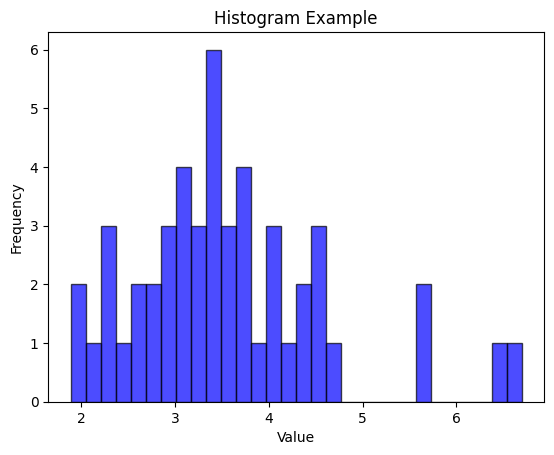

In [20]:
plt.hist(pred, bins=30, color='blue', alpha=0.7, edgecolor='black')

# Add labels and title
plt.title('Histogram Example')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [21]:
pred.head(15)

,xP
name,
Mohamed Salah,6.695048
Bukayo Saka,6.526665
Son Heung-min,5.724308
Martin Ødegaard,5.663548
Cole Palmer,4.726683
Gabriel Martinelli Silva,4.494065
Alejandro Garnacho,4.489856
Conor Gallagher,4.480827
Jarrod Bowen,4.407848
